# Tabular Kaggle Project



### Project Link : 
* https://www.kaggle.com/competitions/playground-series-s3e23/data?select=train.csv
* https://github.com/jasaraujo/DATA-3402_ProjectTemplate
### Challenge Description: 
* Predict whether software will have defects or not based on different metrics that describe the software.
### Data Description: 
* 23 columns and 101763 rows of software characteristics. 22 numerical rows and 1 categorical row (target).

## Data Loading and Initial Look

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [2]:
#load data
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

### Train Head:

In [3]:
#count rows and cols for train 
print("The rows and columns (Target Included) of the train dataset are: ", train.shape, "\nTrain Head:")
train.head()

The rows and columns (Target Included) of the train dataset are:  (101763, 23) 
Train Head:


,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


### Test Head:

In [4]:
#count rows and cols for train 
print("The rows and columns of the test dataset are: ", test.shape, "\nTest Head:")
test.head()

The rows and columns of the test dataset are:  (67842, 22) 
Test Head:


,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,101766,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,101767,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0


### Missing Values:

In [5]:
#find missing values
missing_Tr = train.isnull().sum()
missing_Te = test.isnull().sum()
missing_combined = pd.concat([missing_Tr, missing_Te], axis=1)
missing_combined.columns = ['# of Train Missing', '# of Test Missing']
display(missing_combined)

##double check and duplicate check
print("\nAre there missing values in the train dataset?", train.isnull().values.any())
print("Are there missing values in the test dataset?", test.isnull().values.any())
print("How many duplicates are there within the train dataset?", train.duplicated().sum())
print("How many duplicates are there within the test dataset?", test.duplicated().sum())

,# of Train Missing,# of Test Missing
id,0,0.0
loc,0,0.0
v(g),0,0.0
ev(g),0,0.0
iv(g),0,0.0
n,0,0.0
v,0,0.0
l,0,0.0
d,0,0.0
i,0,0.0



Are there missing values in the train dataset? False
Are there missing values in the test dataset? False
How many duplicates are there within the train dataset? 0
How many duplicates are there within the test dataset? 0


### Train Table of Features:

In [6]:
def feature_summary(df):
    summary = []
    
    for col in df.columns:
        if col == 'id':
            continue

        data = df[col]
        dtype = 'Categorical' if data.nunique() < 5 and data.dtype != float else 'Numerical'
        values = ', '.join(map(str, sorted(data.dropna().unique()))) if dtype == 'Categorical' else f"{data.min()} to {data.max()}"
        missing = data.isnull().sum()
        
        if dtype == 'Numerical':
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            outlier_condition = (data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)
            outliers = outlier_condition.sum()
        else:
            outliers = 0

        summary.append({"Column": col,"Data Type": dtype,"Value Range": values,"# of Missing Values": missing, "# of Outliers (IQR)": outliers,})
    return pd.DataFrame(summary)

feature_table = feature_summary(train)
display(feature_table.style.hide(axis='index'))

Column,Data Type,Value Range,# of Missing Values,# of Outliers (IQR)
loc,Numerical,1.0 to 3442.0,0,8954
v(g),Numerical,1.0 to 404.0,0,9029
ev(g),Numerical,1.0 to 165.0,0,10855
iv(g),Numerical,1.0 to 402.0,0,6954
n,Numerical,0.0 to 8441.0,0,7834
v,Numerical,0.0 to 80843.08,0,8883
l,Numerical,0.0 to 1.0,0,5192
d,Numerical,0.0 to 418.2,0,5490
i,Numerical,0.0 to 569.78,0,4885
e,Numerical,0.0 to 16846621.12,0,12436


### Class Imbalance:

In [7]:
#Class Imbalance
print("Class Distribution %:")
print(train['defects'].value_counts(normalize=True) * 100)

Class Distribution %:
defects
False    77.335574
True     22.664426
Name: proportion, dtype: float64


### Target:

In [8]:
print("Encoded values in target (defects):", train['defects'].unique())

Encoded values in target (defects): [False  True]


## Data Visualization

### Classification: Feature Histograms

loc


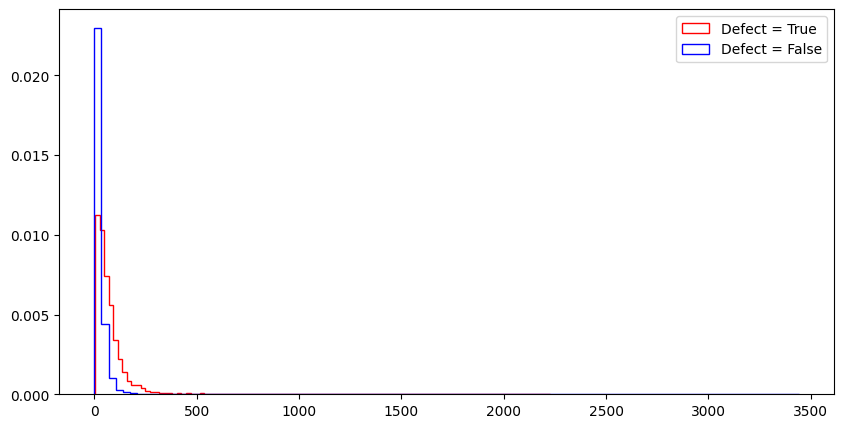

v(g)


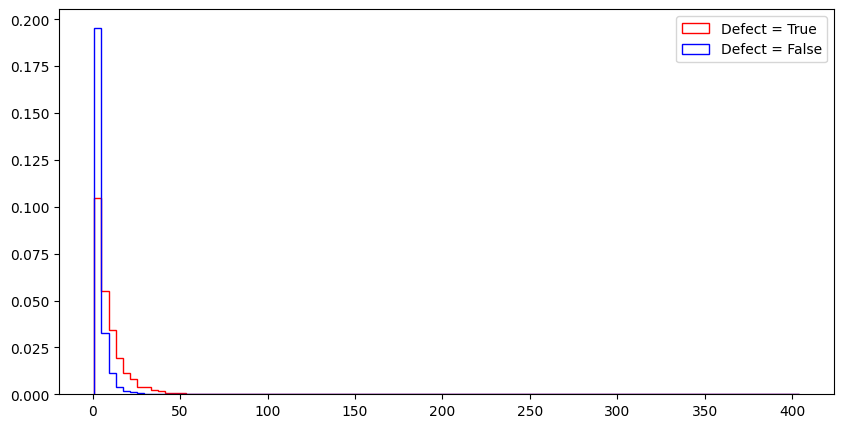

ev(g)


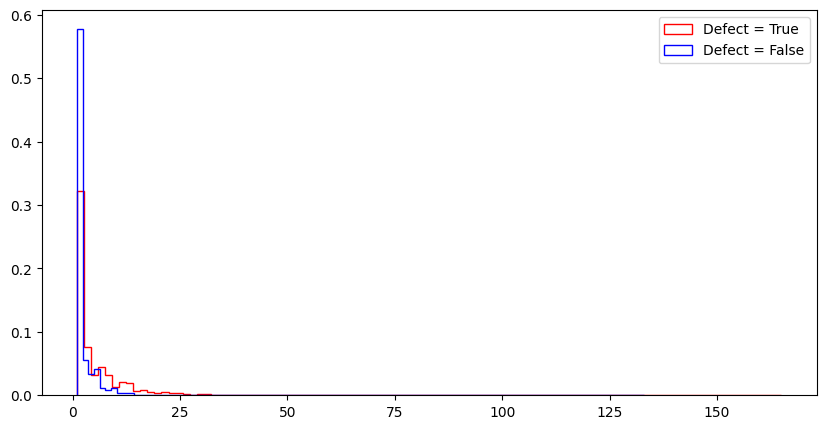

iv(g)


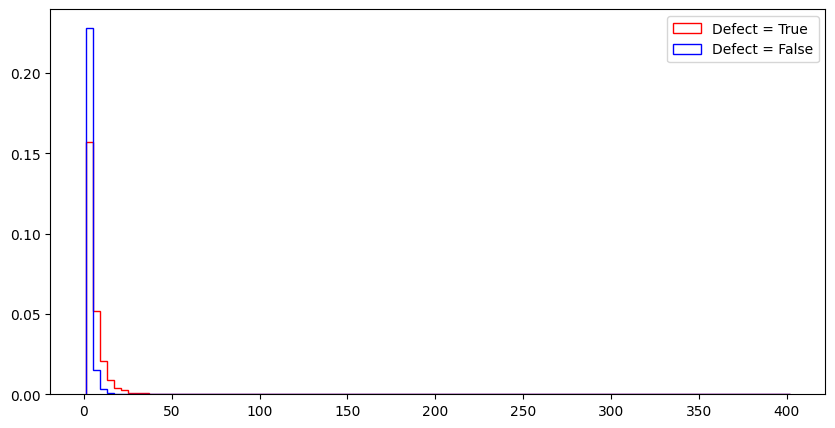

n


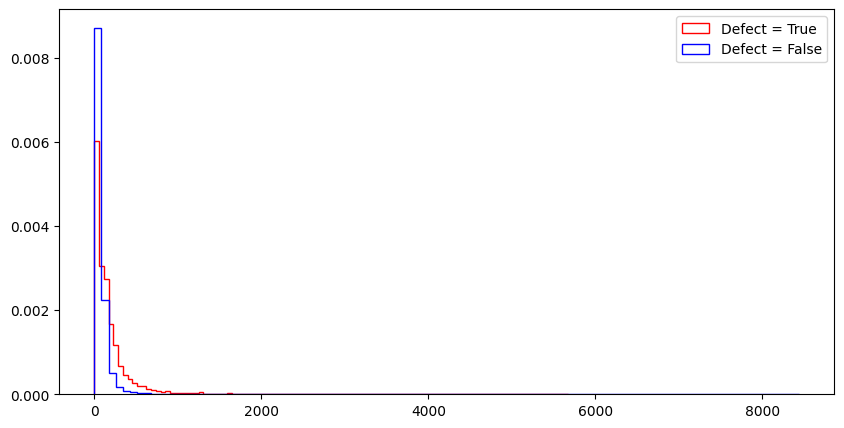

v


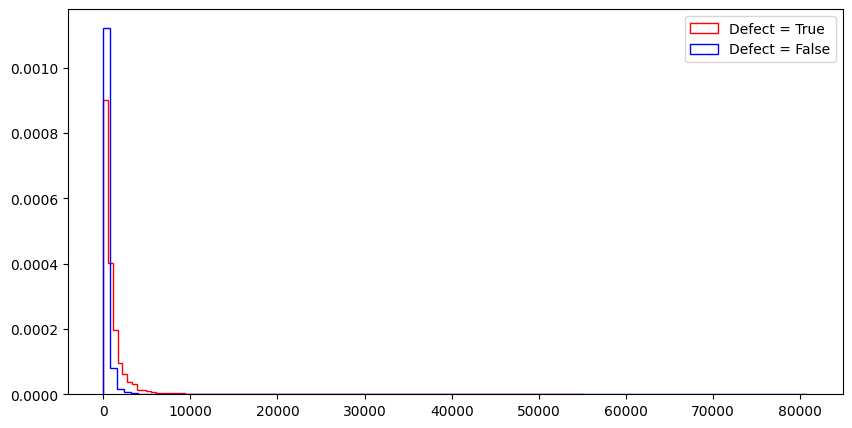

l


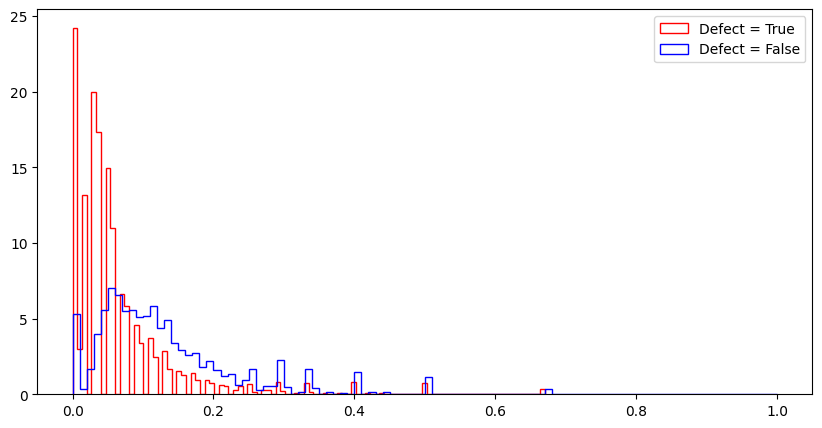

d


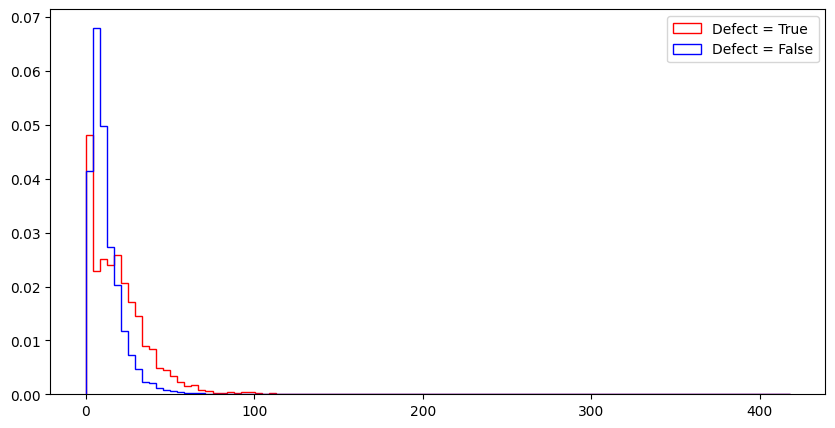

i


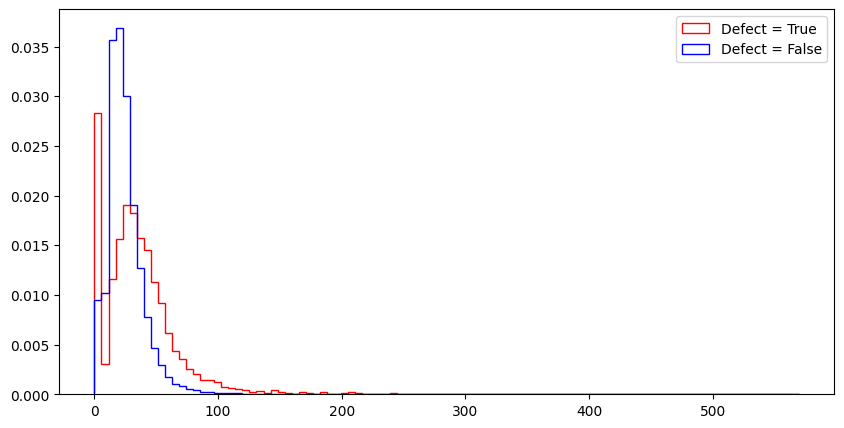

e


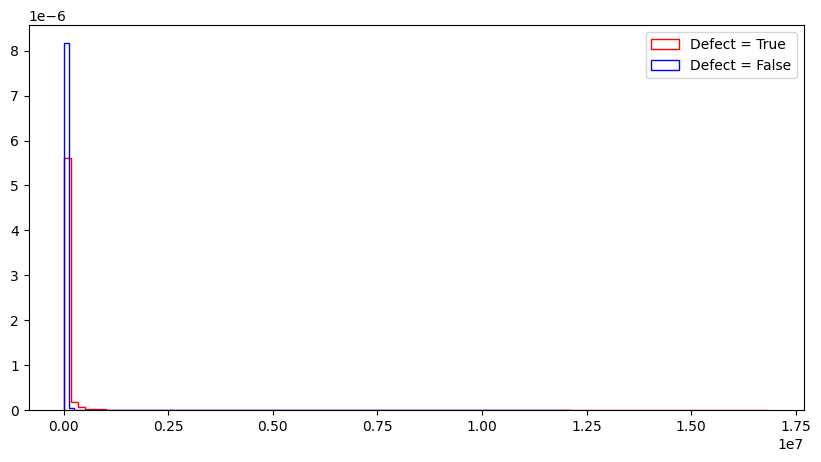

b


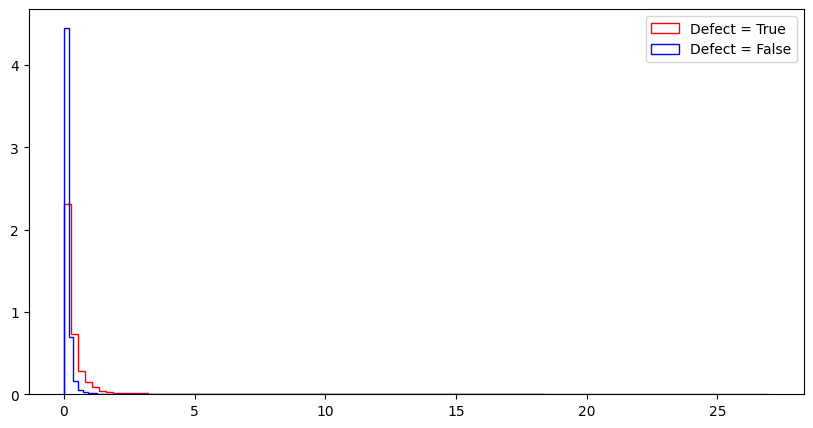

t


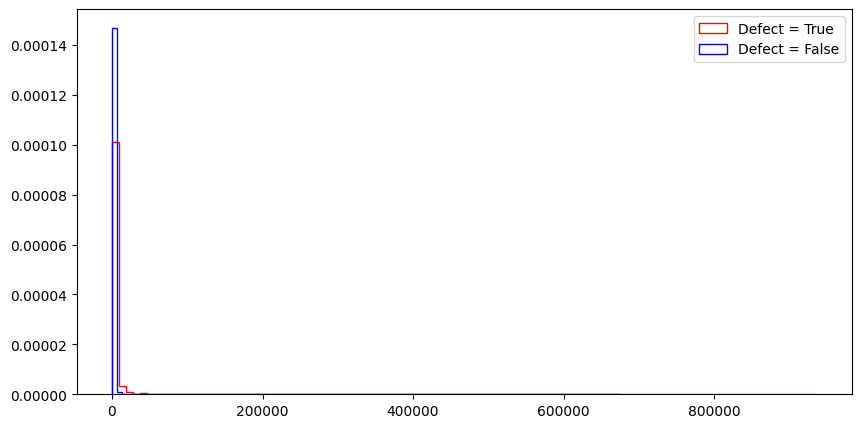

lOCode


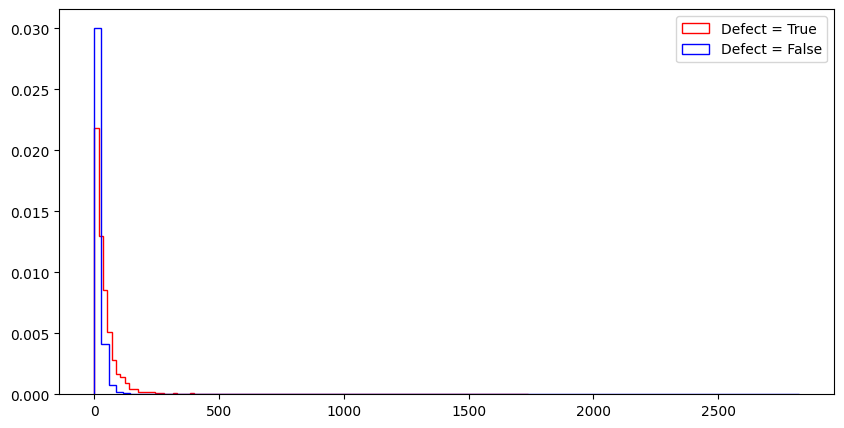

lOComment


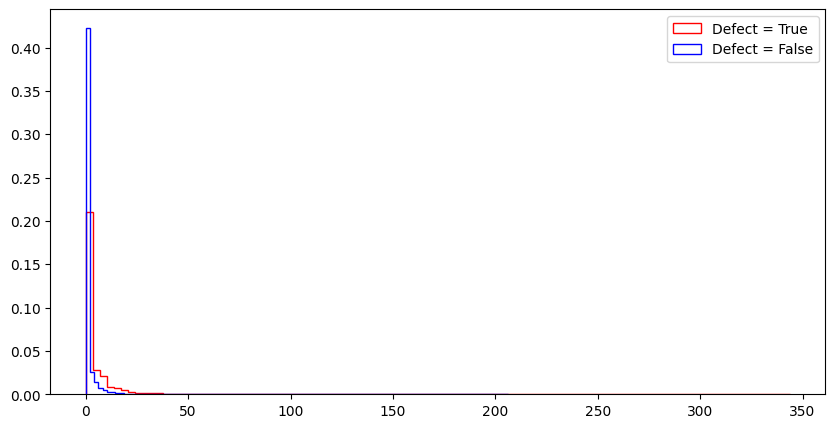

lOBlank


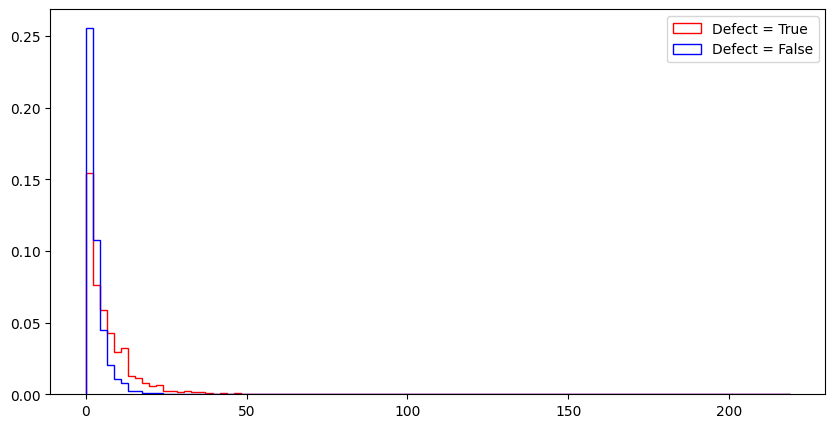

locCodeAndComment


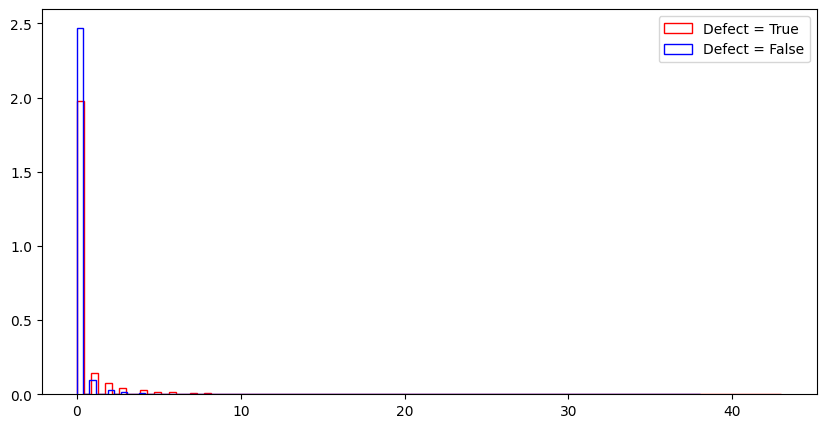

uniq_Op


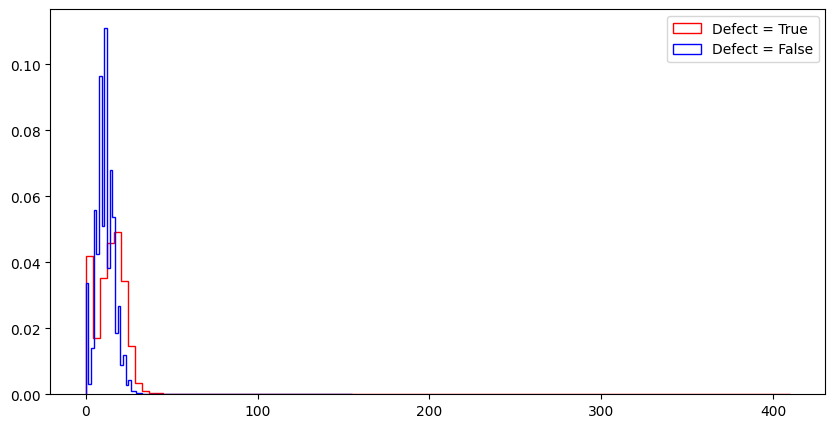

uniq_Opnd


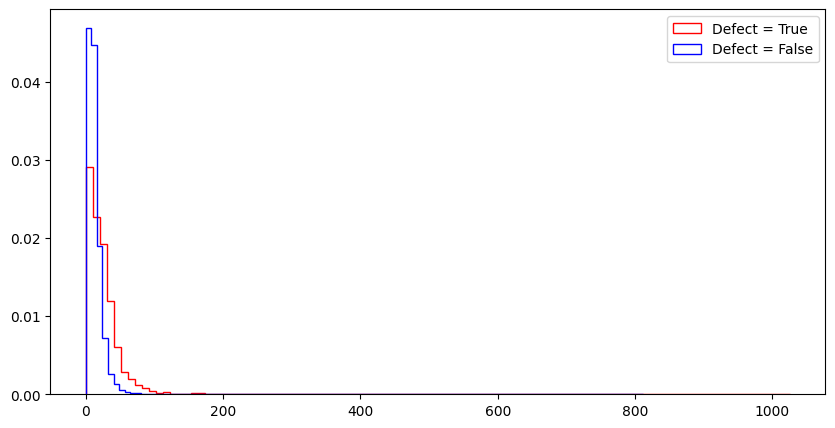

total_Op


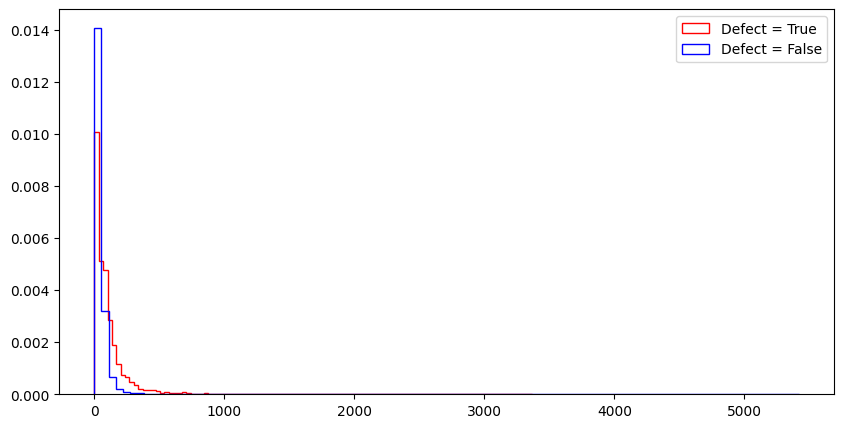

total_Opnd


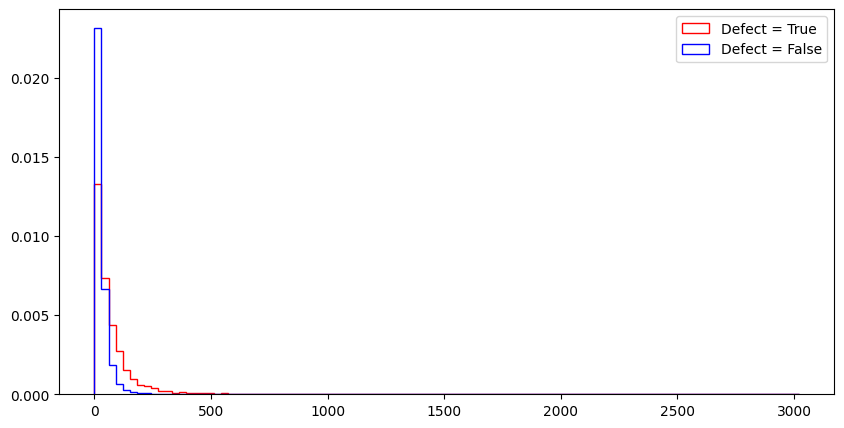

branchCount


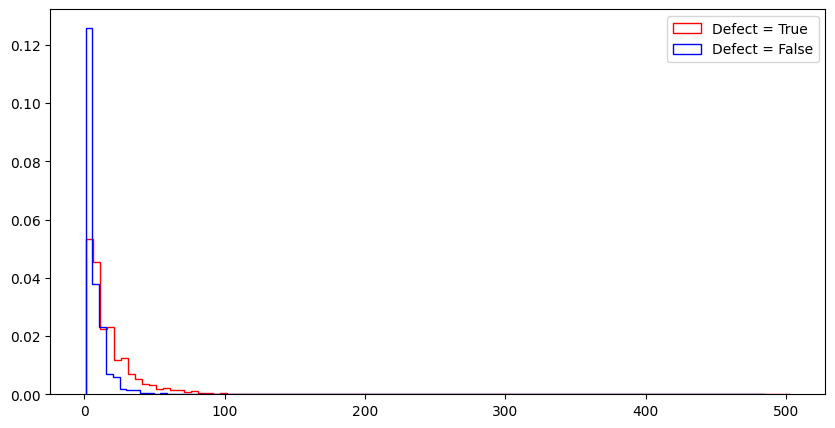

defects


/home/jason/myenv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


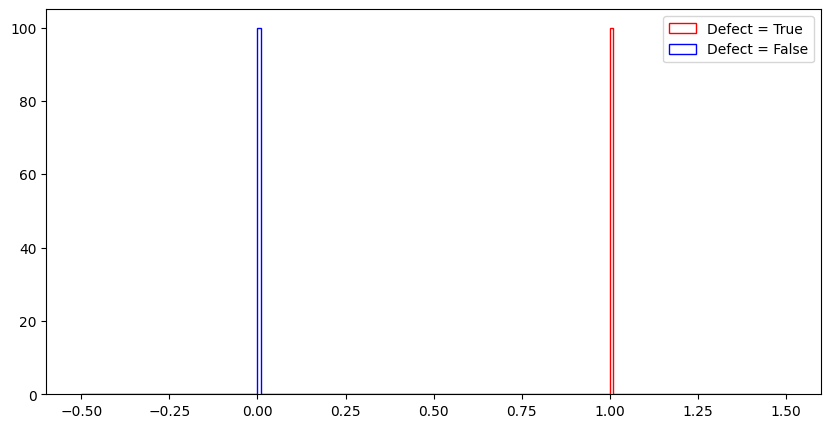

In [9]:
df_def = train[train.defects == True]
df_bkg = train[train.defects == False]

columnNames = list(train.columns)
for name in columnNames[1:]:
    print (name)
    plt.figure(figsize=(10,5))
    plt.hist(np.array(df_def[name]),bins=100,histtype="step", color="red",label="Defect = True",density=1, stacked=True)
    plt.hist(np.array(df_bkg[name]),bins=100,histtype="step", color="blue", label="Defect = False",density=1, stacked=True)
    plt.legend(loc='upper right')
    plt.show()

### Promising Features for ML Task:
* The features l , d , i and uniq_op show clear distribution differences between both classes. Suggesting promising use for ML. 

## Data Cleaning and Preparation for Machine Learning

### Before:

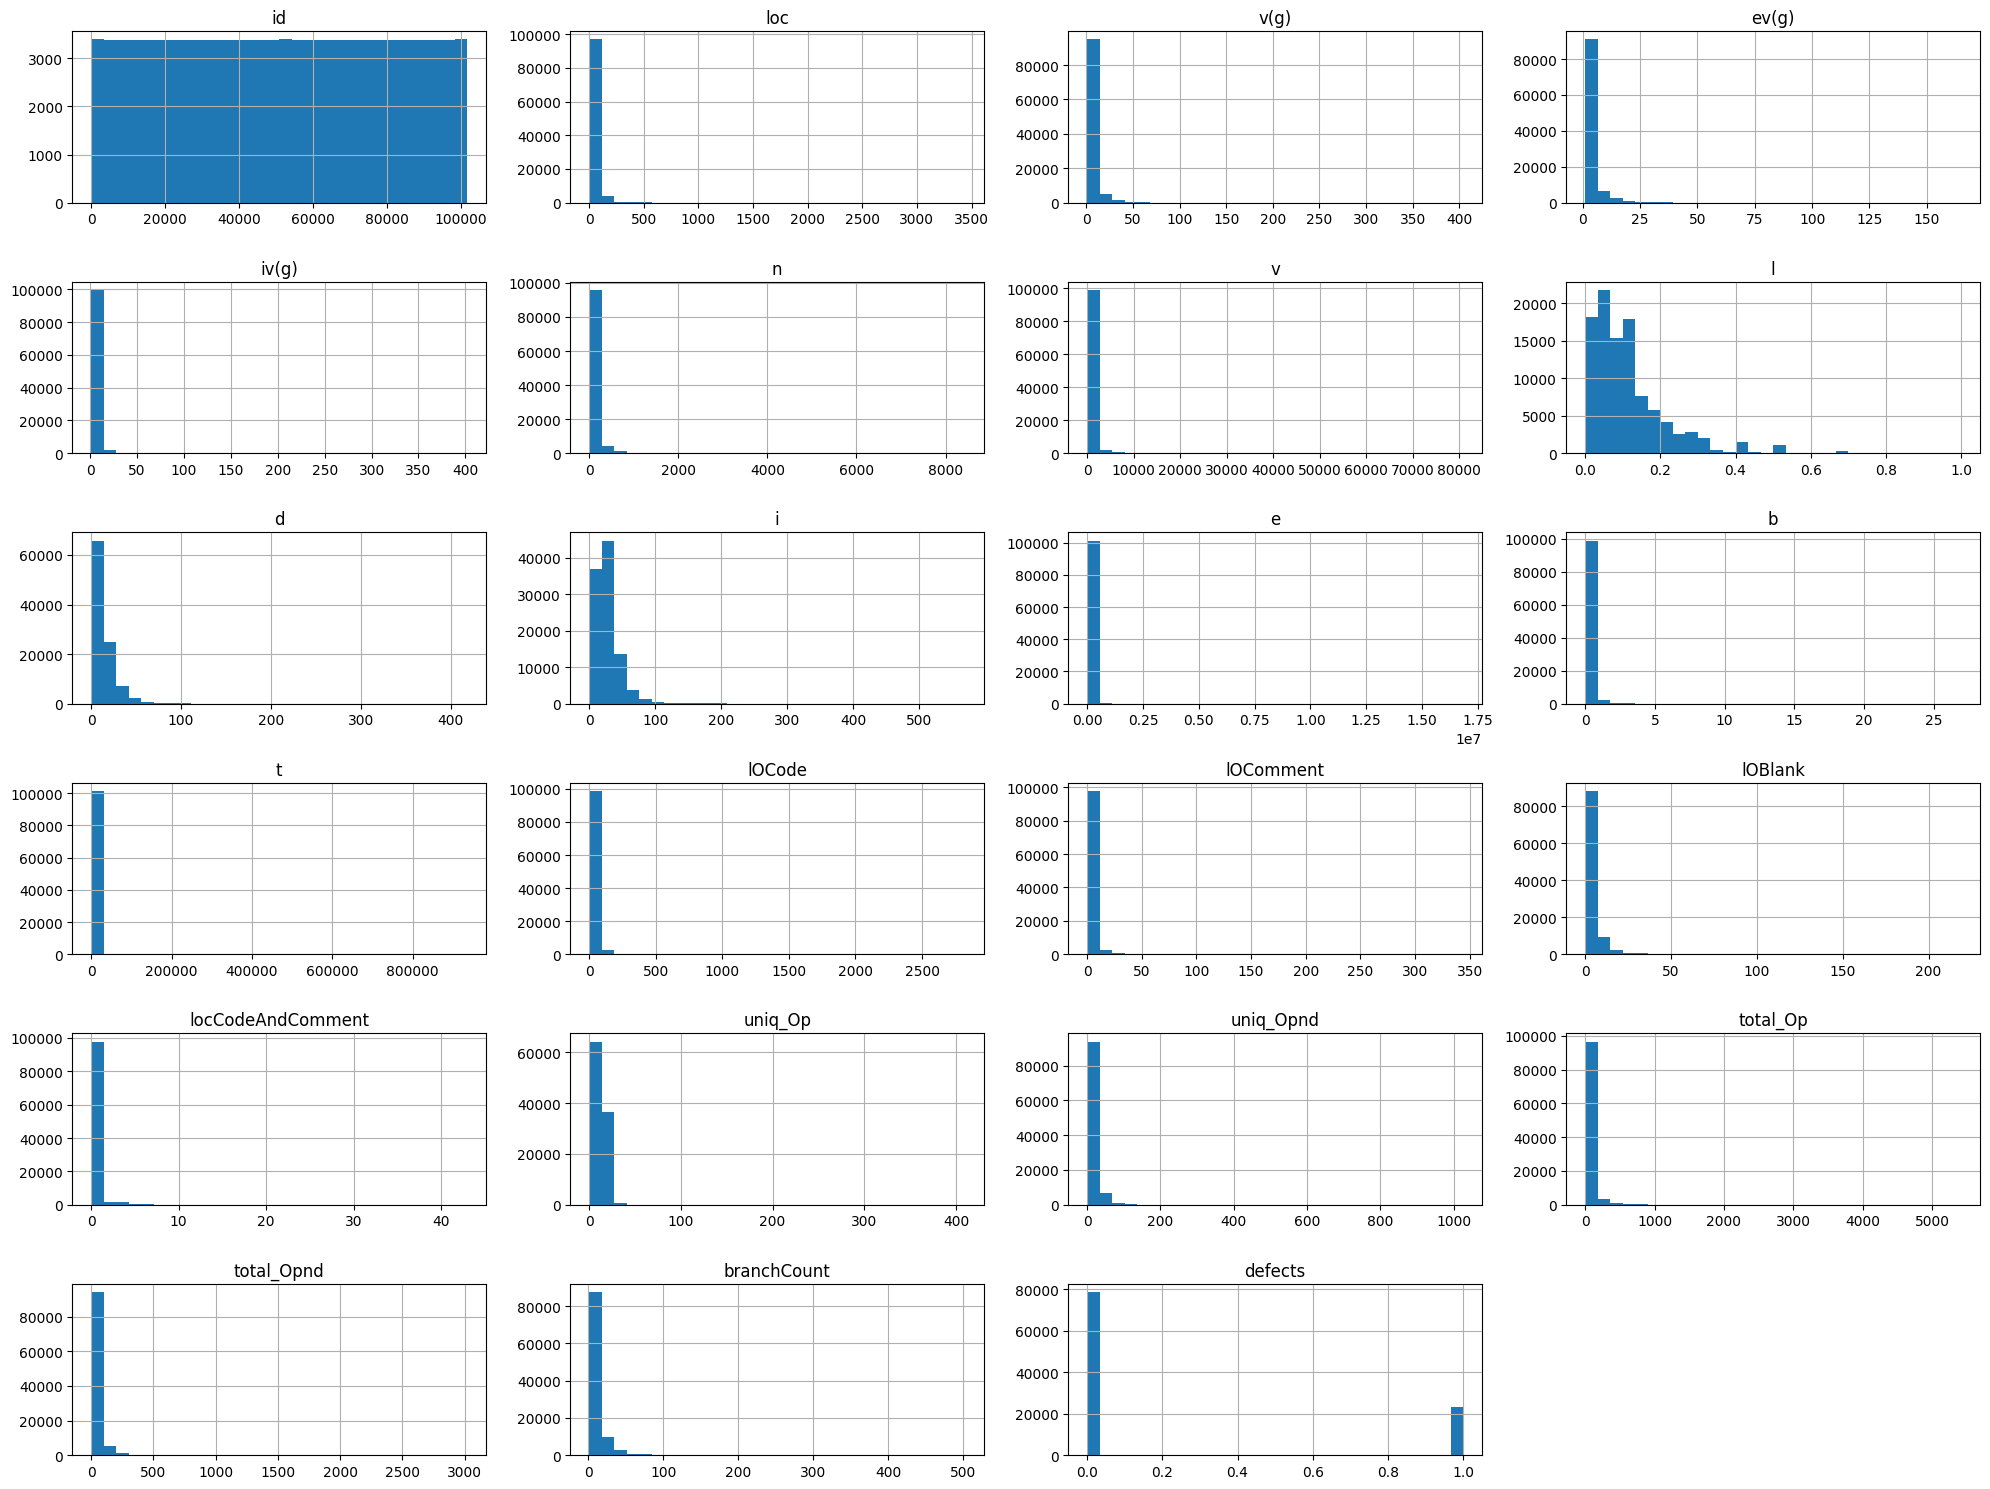

In [10]:
train_copy = train.copy()
train_copy['defects'] = train_copy['defects'].astype(int)  
train_copy.hist(bins=30, figsize=(20, 15), layout=(6, 4))
plt.tight_layout()
plt.show()

### Cleaning:
Removing outliers using IQR for all features except ID and defects 

In [11]:
def remove_outliers(df, exclude_cols=None, k=1.5):
    if exclude_cols is None:
        exclude_cols = []

    df_cleaned = df.copy()
    numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    for col in numeric_cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned

defects
0    91.362748
1     8.637252
Name: proportion, dtype: float64


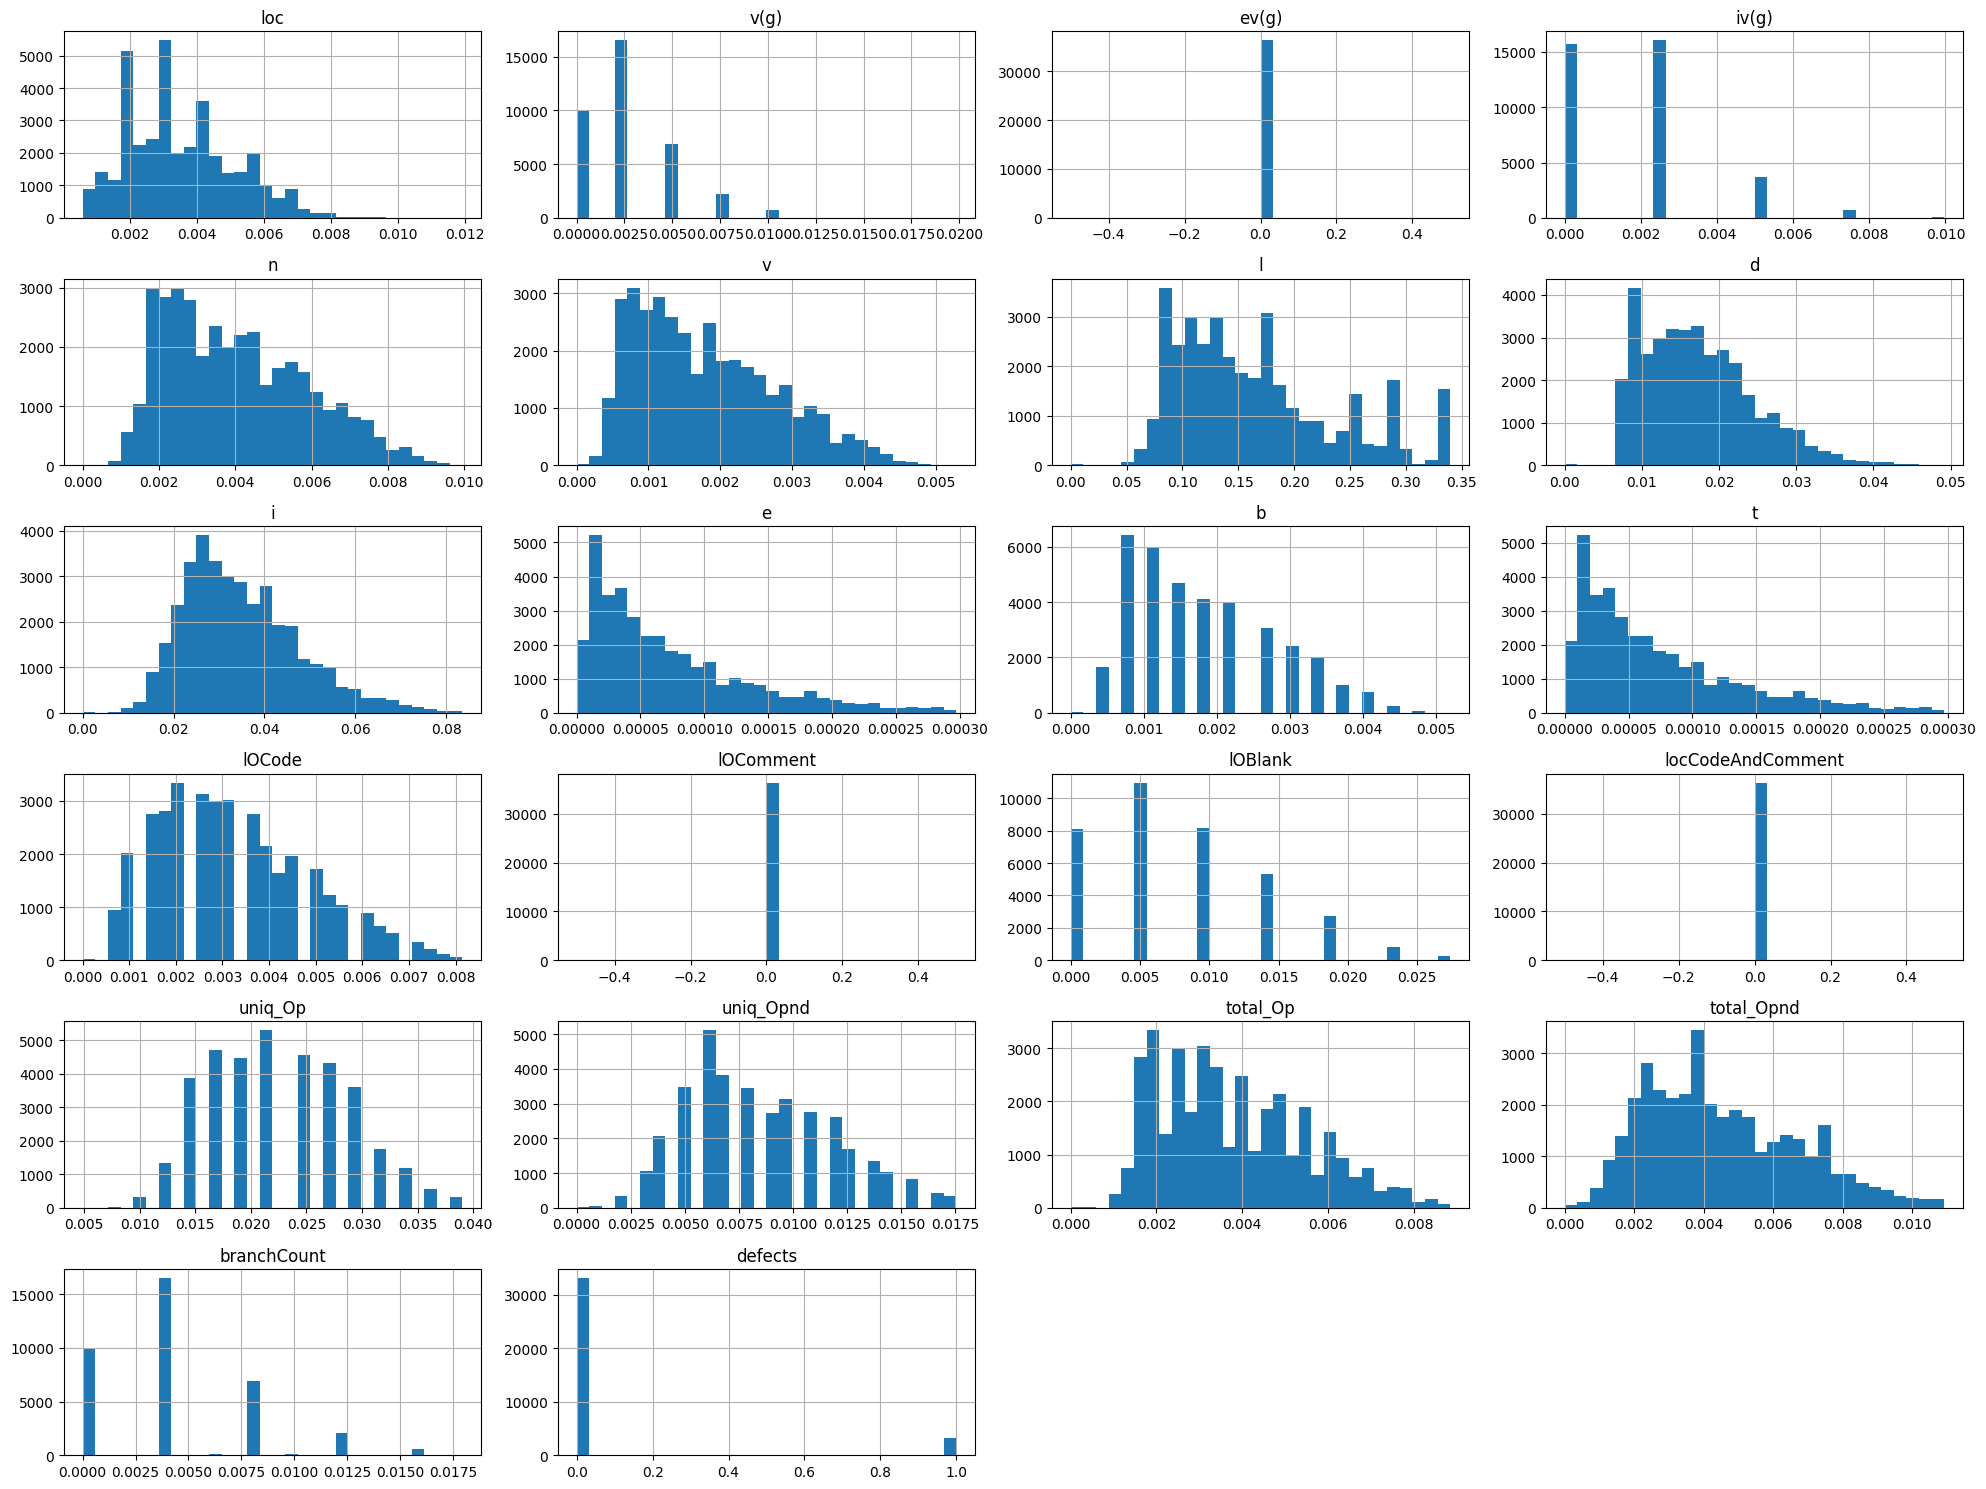

In [12]:
#SCALING FIRST THEN CLEAN
train_sf = train_copy.copy()
x = train_sf.drop(columns=['id', 'defects'])
y = train_sf['defects']

scaler = MinMaxScaler()
train_sf = scaler.fit_transform(x)
train_sf = pd.DataFrame(train_sf, columns = x.columns)
train_sf['defects'] = y.reset_index(drop = True)

train_sf = remove_outliers(train_sf, exclude_cols=['id', 'defects'])
print(train_sf['defects'].value_counts(normalize=True) * 100)
train_sf['defects'] = train_sf['defects'].astype(int)  
train_sf.hist(bins=30, figsize=(20, 15), layout=(6, 4))
plt.tight_layout()
plt.show()

### One-Hot Encode:
* Unable to one-hot encode due to the only catergorical column, my target (defects), is already boolean.

## Machine Learning

### -Problem Formulation: 

In [13]:
def clean_dataset(df,name = "", drop_id=False):
    df_cleaned = df.drop_duplicates().copy()
    
    if drop_id and 'id' in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=['id'])
    
    df_cleaned['defects'] = df_cleaned['defects'].astype(int)
    
    print(f"Data shape for {name} after formulating:", df_cleaned.shape)
    return df_cleaned, df_cleaned.describe()

train_sf, summary = clean_dataset(train_sf,name = "Scale First Train", drop_id=True)
print("\n",summary)

Data shape for Scale First Train after formulating: (36331, 22)

                 loc          v(g)    ev(g)         iv(g)             n  \
count  36331.000000  36331.000000  36331.0  36331.000000  36331.000000   
mean       0.003508      0.002721      0.0      0.001790      0.004020   
std        0.001593      0.002332      0.0      0.001862      0.001829   
min        0.000581      0.000000      0.0      0.000000      0.000000   
25%        0.002325      0.000000      0.0      0.000000      0.002488   
50%        0.003197      0.002481      0.0      0.002494      0.003791   
75%        0.004650      0.004963      0.0      0.002494      0.005331   
max        0.011915      0.019851      0.0      0.009975      0.009951   

                  v             l             d             i             e  \
count  36331.000000  36331.000000  36331.000000  36331.000000  36331.000000   
mean       0.001797      0.164532      0.017242      0.034925      0.000073   
std        0.000970      0.070

### Train ML Algorithm:

In [14]:
def train_random_forest_model(data):
    X = data.drop(columns=['defects'])
    Y = data['defects']

    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

    print("Training set:", X_train.shape)
    print("Validation Set:", X_val.shape)
    print("Test Set:", X_test.shape, "\n")
    print("Training class distribution:\n", Y_train.value_counts(normalize=True))

    rf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1, class_weight='balanced', random_state=42)
    rf.fit(X_train, Y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]  

    print("\nValidation Accuracy:", accuracy_score(Y_val, y_val_pred))
    print("\nClassification Report:\n", classification_report(Y_val, y_val_pred))
    fpr, tpr, _ = roc_curve(Y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(rf, X_train, Y_train, cv=cv, scoring='accuracy')
    print("\nRFC Cross-Validation Scores:", scores)
    print("Avg Accuracy:", scores.mean())
    print(f"ROC:{roc_auc:.4f}") 
    
    cm = confusion_matrix(Y_val, y_val_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(Y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return rf, (X_train, X_val, X_test, Y_train, Y_val, Y_test)

### Evaluate Performance on Validation Sample

Training set: (21798, 21)
Validation Set: (7266, 21)
Test Set: (7267, 21) 

Training class distribution:
 defects
0    0.913616
1    0.086384
Name: proportion, dtype: float64

Validation Accuracy: 0.6632259840352326

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      6639
           1       0.11      0.43      0.18       627

    accuracy                           0.66      7266
   macro avg       0.52      0.56      0.48      7266
weighted avg       0.86      0.66      0.74      7266


RFC Cross-Validation Scores: [0.70068807 0.66399083 0.67821101 0.63592567 0.69190181]
Avg Accuracy: 0.6741434783249252
ROC:0.5901


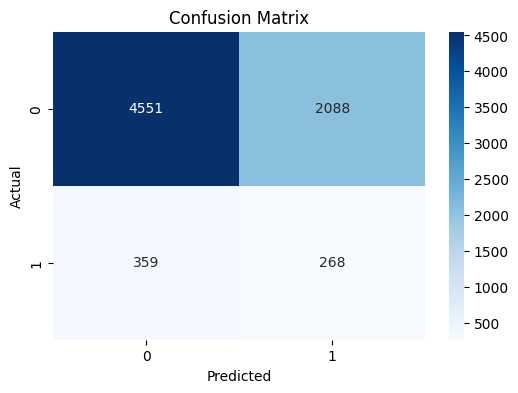

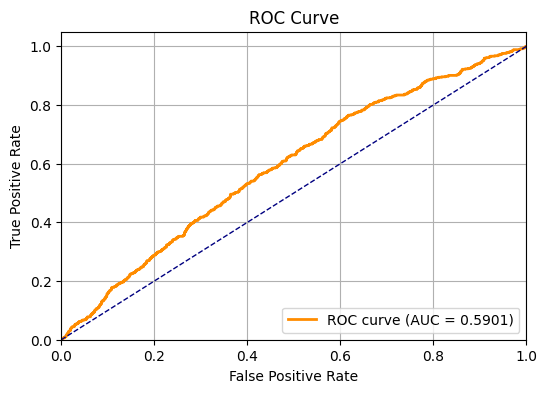

In [15]:
#SCALE FIRST STATS
rf_model, (X_train, X_val, X_test, Y_train, Y_val, Y_test) = train_random_forest_model(train_sf)

## Apply ML to Test:

In [16]:
test_ids = test['id']
test = test.drop(columns=['id'])
test_columns = test.columns

test_scaled = pd.DataFrame(scaler.transform(test), columns=test_columns)
y_test_pred = rf_model.predict(test_scaled)

submission = pd.DataFrame({'id': test_ids, 'defects': y_test_pred})
submission.to_csv("submission.csv", index=False)